# Simple plenoptic example

Maybe for a quick start? Doesn't show anything complicated, but shows the basics.

In [1]:
import plenoptic as po
import torch
import pyrtools as pt

%matplotlib inline

We need a reference image, so load one in.

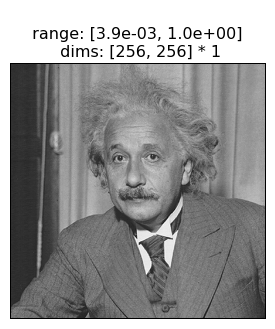

In [2]:
im = po.load_images('../data/einstein.pgm')
fig = po.imshow(im)

Models can be really simple, as this demonstrates. It needs to inherit `torch.nn.Module` and just needs two methods: `__init__` (so it's an object) and `forward` (so it can take an image.

In [3]:
## REPLACE WITH CONV OR LN MODEL

class SimpleVisualModel(torch.nn.Module):
    """A simplified RGC model
    """
    def __init__(self, scaling, img_res, min_ecc=.5, max_ecc=15, std_dev=1):
        super().__init__()
        self.PoolingWindows = po.simul.PoolingWindows(scaling, img_res, min_ecc, max_ecc,
                                                     window_type='gaussian', std_dev=std_dev)
        self.representation = None
        
    def forward(self, image):
        self.representation = self.PoolingWindows(image)
        return self.representation

Now we initialize the model and call its forward method

In [4]:
model = SimpleVisualModel(1, im.shape[-2:])
rep = model(im)

We see that `im` is a 4d tensor (batch by channel by height by width) and that our model returns a 3d representation (batch by channel by something). Models need to take in 4d tensors and return 3d or 4d.

In [5]:
print(im.shape)
print(rep.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 403])


And we see it's just a bunch of floats

In [6]:
rep[..., :50]

tensor([[[0.5881, 0.5338, 0.4690, 0.4175, 0.3991, 0.4075, 0.4285, 0.4499,
          0.4590, 0.4488, 0.4183, 0.3807, 0.3659, 0.3847, 0.4240, 0.4713,
          0.5095, 0.5016, 0.4501, 0.4477, 0.5100, 0.5588, 0.5560, 0.5184,
          0.4891, 0.4973, 0.5339, 0.5873, 0.6412, 0.6552, 0.6296, 0.6066,
          0.5407, 0.4780, 0.4616, 0.4900, 0.5280, 0.5529, 0.5607, 0.5507,
          0.5210, 0.4737, 0.4202, 0.3812, 0.3759, 0.4107, 0.4708, 0.5293,
          0.5470, 0.5216]]])

Now initialize the metamer object, which requires the model and the reference image

In [7]:
metamer = po.synth.Metamer(im, model)

And call `synthesize`. This has a handful of optional arguments. You'll probably need to play around with some of the optimization-related ones, like `max_iter`, `learning_rate`, and `optimizer` (see the `Metamer` dosctring or notebook for more info), and you probably want to set `store_progress` to `True` (to store every iteration) or some `int` (to store every `int` iterations) so you can examine synthesis progress.

In [8]:
matched_im, matched_rep = metamer.synthesize(store_progress=True, learning_rate=.1, optimizer='Adam')

100%|██████████| 100/100 [00:12<00:00,  8.19it/s, gradient_norm=1.0625e-01, learning_rate=0.0125, loss=1.5425e-02]


We can then look at the reference and metamer images:

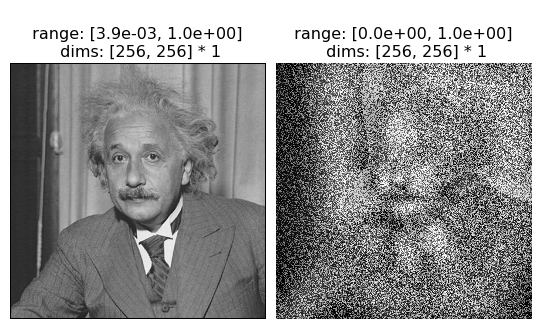

In [9]:
fig = po.imshow([im, matched_im]);

And view a movie of our progress so far

In [10]:
po.convert_anim_to_html(metamer.animate(plot_representation_error=False, figsize=(12, 5)))

In a similar fashion, we can call `MADCompetition`. It requires two models, so we compare it against the `Identity` model, which just returns a copy of the image, and thus is roughly equivalent to using mean-squared error as a metric (we actually use the L2-norm, but you can change that if you'd like)

In [11]:
mad = po.synth.MADCompetition(im, model, po.simul.models.naive.Identity())

And again, call `synthesize`. `MADCompetition` has similar attributes, but one big difference is that its stimuli come in sets of 4, so you have to set the synthesis target (see the `MADCompetition` docstring or notebook for more info).

In [12]:
matched_im, matched_rep_1, matched_rep_2 = mad.synthesize('model_1_min', store_progress=True, optimizer='Adam',)

100%|██████████| 100/100 [00:19<00:00,  5.53it/s, gradient_norm=2.4886e-01, learning_rate=0.00195, loss=6.8287e-02, stable_loss=9.9954e-01]


And similarly, we can view an animation to see the progress. Notice there are two losses here, one for each model.

In [13]:
po.convert_anim_to_html(mad.animate(plot_representation_error=False, figsize=(12, 5)))

/home/billbrod/Documents/plenoptic/plenoptic/synthesize/Synthesis.py:1593: UserWarning: Looks like representation is image-like, haven't fully thought out how to best handle rescaling color ranges yet!
  warnings.warn("Looks like representation is image-like, haven't fully thought out how"
